In [2]:
import scanpy as sc
import sys
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp

%reload_ext autoreload
%autoreload 2

2023-08-30 12:00:02.465036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Code stolen (borrowed) to the amazing Ka Wai Lee

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

In [5]:
remove_genes = ['IGHM', 'CCL16', 'CCR3','CD3G','TH','NEUROD6','CD4','PLP1']

In [4]:
adata = sc.read_h5ad('../EEL_AnnData/EEL_41CleanNuclei-CellularNgh_FeaturesMN.h5ad')
adata = adata[:,~adata.var_names.isin(remove_genes)]
#GW high samples
adata = adata[adata.obs.Sample.isin(
        [
            'SL005','SL006','SL011','SL013','SL016A','SL016B','SL019','SL020','SL023','SL029','SL030','SL034','SL035A','SL035B',
            'SL037', 'SL038','SL040B','SL040Bulk','SL040D','SL040E','SL046A','SL046B','SL046C','SL047B','SL057A','SL061A','SL061B']
    )
]

In [6]:
adata = sc.read_h5ad('../DataSubmission/GBM_Linnarsson_EEL.h5ad')
adata = adata[:,~adata.var_names.isin(remove_genes)]
#GW high samples
adata = adata[adata.obs.Sample.isin(
        [
            'SL005','SL006','SL011','SL013','SL016A','SL016B','SL019','SL020','SL023','SL029','SL030','SL034','SL035A','SL035B',
            'SL037', 'SL038','SL040B','SL040Bulk','SL040D','SL040E','SL046A','SL046B','SL046C','SL047B','SL057A','SL061A','SL061B']
    )
]

In [9]:
adata.obs['m-states'].cat.categories
adata.raw = adata

In [86]:
adata.X = adata.raw.X
#sp.pp.preprocess(adata,log=False) the good one
#sp.pp.preprocess(adata,normalize_mode='l2',log=True,batch_correction=False)

In [89]:

GW_clusters = ['GW-like 1', 'GW-like 2', 'GW-like 3', 'GW-like 4', 'GW-like 5', 'GW-like 6', 'GW-like 7', 'GW-like 8']
GW = adata[adata.obs['m-states'].isin(GW_clusters)]
#sp.pp.preprocess(GW,log=False) #the good one


In [90]:
import numpy as np
#GW = GW[GW.raw.X.sum(axis=1)> 20]


In [91]:
from tqdm import tqdm

GWs = []
for c in tqdm(GW.obs['m-states'].cat.categories):
    ad = GW[GW.obs['m-states'] == c]
    try:
        mini = sc.pp.subsample(ad,n_obs=10000,copy=True)
    except:
        mini = ad
    GWs.append(mini)
GW_mini = GWs[0].concatenate(*GWs[1:])

100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.77it/s]


In [116]:
GW_mini = GWs[0].concatenate(*GWs[1:])
GW_mini
sp.pp.preprocess(GW_mini,log=True) #the good one

In [117]:
latent_time = GW_mini[:,'VEGFA'].X.toarray()
GW_mini.obs['latent_time'] = latent_time

In [118]:
GW_mini = GW_mini[:,GW_mini.X.sum(axis=0)> 0]
GW_mini

View of AnnData object with n_obs × n_vars = 73531 × 873
    obs: 'Area', 'CellID', 'Centroid', 'Polygons', 'Sample', 'X', 'Y', 'batch', 'ID', 'CellularNgh', 'm-states', 'm-states80', 'latent_time'
    var: 'Accession', 'Gene'
    uns: 'log1p'
    obsm: 'spatial'

In [119]:
gene_list = GW.var_names
gene_list = gene_list[gene_list != 'VEGFA']

In [120]:
# This genes (marker genes enriched accross Wound Response subtypes) are only kept if logfold is positive and pval < 0.05
highlight_genes = [
    'TGFBI','TNF','EPAS1','STAT1','STAT3','NOTCH1','SLC2A1','TGFB2','TGFB3',
    'STMN1','TIMP1','CCL2','HIF1A','HMOX1','TGFA','NFKB1','ASCL1',
    'TNC','GAP43','IDH1','ATF3','LAGLS1','ANXA1','IGFBP5','PLAU','PLAUR','SERPINE1',
    'IL17RA','IL3','CD44',
]

In [121]:
import seaborn as sns

In [122]:
reds = sns.color_palette('Reds',9)

In [123]:
lout = sp.tl.pseudotime_genes(
    GW_mini,
    gene_list,
    cluster_key='m-states',
    clusters=GW_clusters,
    #n_bins=[.15, .25,.35, .45,.55, .95, 1 ],
    n_bins=6,
    min_logfold=0.1,
    min_pval=0.05,
    highlight_genes=highlight_genes
)

/wsfish/glioblastoma/FISHspace/tools/pseudotime.py:76: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  time_adata.obs['lineage_Clusters']=np.repeat(0,time_adata.shape[0])


/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'Sample' as categorical
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'm-states' as categorical


bin 0
bin 1
bin 2
bin 3
bin 4
bin 5


  0%|          | 0/872 [00:00<?, ?gene/s]

In [41]:
paletteGW = {
    'GW-like 2': '#EDE8F3',
    'GW-like 3': '#E2D8EA',
    'GW-like 1': '#D6BEDD',
    'GW-like 5': '#CFA8D1',
    'GW-like 7': '#e43c96',
    'GW-like 8': '#C50F53',
    'GW-like 4': '#A40447',
    'GW-like 6': '#840034'
    
}

paletteGW_RGB = {x:mcolors.hex2color(paletteGW[x]) for x in paletteGW}
attr_colour = {'Clusters':paletteGW}

In [42]:
import matplotlib.pyplot as plt
import numpy as np
#import mplt as mplot
tidy_gene_in_order = lout['tidy_gene_in_order']
sub_adata = lout['sub_adata']
attr = dict()
attr_ = ['CombinedNameMerge', 'Sample','latent_time']
attr_ = (sub_adata.obs[attr_]).to_dict('list')
attr['CombinedNameMerge'] = [str(i) for i in attr_['CombinedNameMerge']]
attr['Latent time'] = attr_['latent_time']

lt = np.array(attr['Latent time'])
lt_norm = plt.Normalize(vmin=lt.min(),vmax=lt.max())(lt)

attr_colour['Latent time'] = plt.cm.inferno(lt)

In [49]:
highlight_genes += ['ANXA2']

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 40 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'a', 'b', 'd', 'e', 'five', 'four', 'g', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 'seven', 'space', 't', 'three', 'two']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 20, 21, 22, 23, 24, 26, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 59, 68, 69, 71, 72, 74, 76, 80, 81, 82, 85, 87]
INFO:fontTools.subset:Closed glyph list over 'G

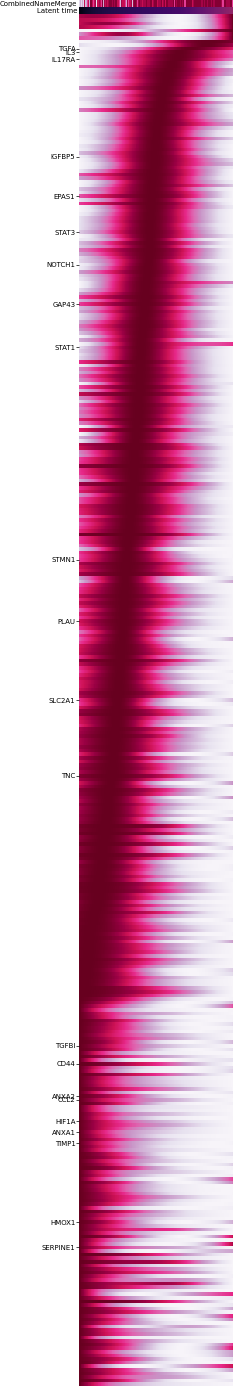

In [50]:
# attr.pop('latent_time')
sp.pl.pseudotime_heatmap(
    lout['data_processed'],
    tidy_gene_in_order,
    figsize=(2,18),
    attr= attr,
    plot_time=True,
    attrs_type=np.array(['s','s']),
    attrs_color= {'CombinedNameMerge':paletteGW_RGB,'Latent time':{l:c for l,c in zip(attr['Latent time'], plt.cm.inferno(attr['Latent time']) )}} ,
    fontsize=5,
    skip='skip',
    cmap='PuRd',
    highlight=highlight_genes,
    save=True,
    savepath='figures/VEGFA_pseudotimeMinMax2.pdf'
)
